# Lesson 9.05 Recurrent Neural Networks

## Build a basic RNN to solve a NLP task

### Load Data

In [1]:
# Load cleaned data and split into training and test set
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]

# if label is spam, set it to 1
# if label is ham, set it to 0
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'], labels, test_size=0.2)

### Prepare Data

In [2]:
# Install keras
# !pip install -U keras

In [3]:
# Import the tools we will need from keras

# Tokenizer function will clean and tokenize data
# By default, all punctuation is removed, turning the texts into space-separated sequences of words 
# (words maybe include the ' character). These sequences are then split into lists of tokens. 
# They will then be indexed or vectorized.
# More info at https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()

# Train the tokenizer and use the tokenizer to convert sentences to sequences of numbers
# where each number represents the index of the word stored in the tokenizer
tokenizer.fit_on_texts(X_train)

In [5]:
# Use that tokenizer to transform (convert) the text message strings in training and test data
# into a list of integers where each integer represents the index of that word
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
# Q: What do these sequences look like?
# Ans: sequence of numbers representing the words in each text msg
# Ans: specifically this is the integer representation of the first text msg in data set
# Ans: in other words, each integer is representing a word in the first text msg
X_train_seq[0]

[2593,
 8,
 3895,
 1032,
 32,
 1147,
 52,
 254,
 31,
 10,
 24,
 185,
 5,
 209,
 37,
 33,
 3896,
 602,
 402,
 17,
 4,
 3897,
 1664]

In [7]:
# we need to standardize the sequence length since ML models expect the same number of features
# for every training example that it sees

# in our case, RNN model requires each sentence or each list of integers to be the same length

# Pad the sequences so each sequence (vector) is the same length
# Truncate anything that is longer than 50 down to 50 and pad anything that is shorter with zeros
# Sequence length is one of the parameters that can be optimised via hyperparameter tuning
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [8]:
# Display padded sequence for first text message which has included zeros to ensure sequence length = 50
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 2593,    8, 3895, 1032,   32, 1147,
         52,  254,   31,   10,   24,  185,    5,  209,   37,   33, 3896,
        602,  402,   17,    4, 3897, 1664])

### Build Model

In [9]:
# Import the tools needed from keras

# facilitate the computation of performance metrics
import keras.backend as K

# type of layers required

# RNNs have a short-memory that allow them to store the information processed by the previous layers.
# LSTMs are an extension of RNNs whose goal is to “prolong” or “extend” this internal memory
# hence allowing them to remember previous words, previous sentences or any other value from the
# beginning of a long sequence.
from keras.layers import Dense, Embedding, LSTM

# type of model required
from keras.models import Sequential

# define custom functions to calculate recall and precision
def recall_m(y_true, y_pred):
        # K.round: Element-wise rounding to the closest integer
        # K.clip: Element-wise value clipping to min and max values specified
        # K.epsilon: When there's a division operation taking place, it's often added to denominator to prevent
            # a divide by zero error. Epsilon is small value that makes very little difference to the value of 
            # the denominator, but ensures that it isn't equal to exactly zero.
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [10]:
# Create a RNN model
model = Sequential()

# Add Embedding layer which will take the text msg that is being passed in and create an embedding
# or vector representation of that text msg

# 'len(tokenizer.index_word)+1' refers to input dimensionality i.e. how many words are there in total
# Need to add 1 to get full dimensionality since count starts from zero
# Instructs embedding layer how many words to expect as input

# '32' refers to the output dimensionality or in other words create embeddings of length=32
# This is a parameter that you may consider tuning as part of model optimization
model.add(Embedding(len(tokenizer.index_word)+1, 32))

# LSTM (Long Short Term Memory) layer is a type of RNN layer used when the chain of input-chunks becomes longer 
# '32' refers to the outout dimensionality which equals to input dimensionality of current layer
# Since it is a sequential model the output of previous layer will be passed as input to this LSTM layer
model.add(LSTM(32))

# fully connected layer i.e. every node is layer is connected to every node in the layer before
model.add(Dense(32, activation='relu'))

# Take 32 dimensions from the layer before and output one dimension
# Condense everything down to make a prediction of either spam or ham 
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256192    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 265,601
Trainable params: 265,601
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', # standard option for binary target variables
              metrics=['accuracy', precision_m, recall_m]) # metrics to display

In [12]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10, # batch_size = number of samples per epoch while epoch = number of loops
                    validation_data=(X_test_seq_padded, y_test)) # apply model to unseen data i.e. test data

Epoch 1/10
140/140 [==============================] - 3s 18ms/step - loss: 0.2696 - accuracy: 0.9154 - precision_m: 0.5032 - recall_m: 0.4135 - val_loss: 0.0559 - val_accuracy: 0.9848 - val_precision_m: 0.9550 - val_recall_m: 0.9154
Epoch 2/10
140/140 [==============================] - 2s 13ms/step - loss: 0.0367 - accuracy: 0.9904 - precision_m: 0.9762 - recall_m: 0.9458 - val_loss: 0.0384 - val_accuracy: 0.9865 - val_precision_m: 0.9655 - val_recall_m: 0.9202
Epoch 3/10
140/140 [==============================] - 2s 13ms/step - loss: 0.0151 - accuracy: 0.9962 - precision_m: 0.9943 - recall_m: 0.9845 - val_loss: 0.0379 - val_accuracy: 0.9883 - val_precision_m: 0.9574 - val_recall_m: 0.9314
Epoch 4/10
140/140 [==============================] - 2s 13ms/step - loss: 0.0072 - accuracy: 0.9987 - precision_m: 0.9831 - recall_m: 0.9815 - val_loss: 0.0348 - val_accuracy: 0.9910 - val_precision_m: 0.9964 - val_recall_m: 0.9226
Epoch 5/10
140/140 [==============================] - 2s 14ms/step -

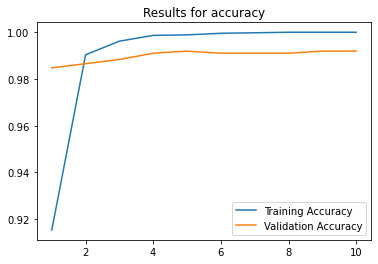

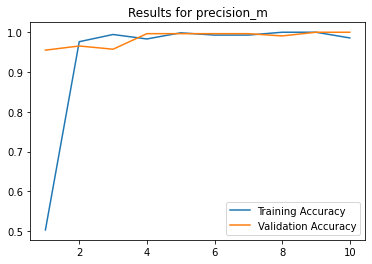

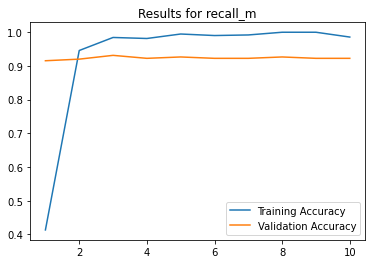

In [13]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()
    
    # validation accuracy, precision and recal appears to be relatively consistent over time